In [57]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import factorial as factorial
import pandas as pd
from tqdm import tqdm
import seaborn as sn
import sys
from pathlib import Path
import matplotlib as mpl

# import custom functions from src folder
module_path = str(Path.cwd() / "../src")

if module_path not in sys.path:
    sys.path.append(module_path)

from util import *

In [65]:
def polar_to_cartesian(r, a):
    x = r*np.cos(a)
    y = r*np.sin(a)
    return x, y

def cartesian_to_polar(x, y):
    r = np.sqrt(x**2 + y**2)
    a = np.arctan(y/x)
    #Get angles in range 0, 2pi (tested)
    a = np.where(x < 0, a + np.pi, a)
    a = np.where(a < 0, a + 2*np.pi, a)
    return r, a

In [26]:
def plot_results(df, predkey, ax, suptitle):
    ax.set_title(suptitle)
    sn.set_theme(style="whitegrid")
    cmap = red_blue_cmap()

    sn.scatterplot(data = df, x="x1", y="x2", ax = ax, hue=predkey, 
                   hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False),
                    palette=cmap, legend=False)
    
    ax.set_xlim(-25, 25)
    ax.set_ylim(-25, 25)
    return ax


In [13]:
def alpha(a2, r1, r2):
    return (r2*np.sin(a2)/(r1+r2*np.cos(a2)))

def beta(x1, x2, r1, r2):
    return((x1**2+x2**2-(r1**2+r2**2))/(2*r1*r2))

def theta2(x1, x2, r1, r2):
    val = beta(x1, x2, r1, r2)
    # We can get some rounding errors. If they are tiny, skip them.
    if (abs(val) > 1) and (abs(val) - 1 < 0.001):
        if val < 0:
            val = -1 + 0.001
        else: val = 1 - 0.001
    elif (abs(val) > 1) and (abs(val) - 1 > 0.001):
        print(f"Encountered strange beta value: {val} from input x1 {x1}, x2 {x2}.")
    return(np.arccos(val))

def theta1(x1, x2, r1, r2):
    #Piecewise defined
    a1 = np.arctan(x2/x1)-np.arctan(alpha(theta2(x1, x2, r1, r2), r1, r2))
    a1 = np.where(x1 < 0, a1 + np.pi, a1)
    a1 = np.where(a1 < 0, a1 + 2*np.pi, a1)
    if any(x < 0 for x in a1.flatten()) == True:
        print(f"Encountered strange theta1 value: {a1} from input x1 {x1}, x2 {x2}.")
    elif any(x > 2*np.pi for x in a1.flatten()) == True:
        print(f"Encountered strange theta1 value: {a1} from input x1 {x1}, x2 {x2}.")
    return a1

def delta(x1, x2, r1, r2):
    a2 = theta2(x1, x2, r1, r2)
    A = alpha(a2, r1, r2)
    B = beta(x1, x2, r1, r2)
    return (2*A/(1-B**2**2)*(A**2 + 1))*(1/np.tan(a2) + A)

def da2dx(x1, x2, r1, r2):
    return -2*x1/(1-beta(x1, x2, r1, r2)**2)

def da2dy(x1, x2, r1, r2):
    return (-2*x2/(1-beta(x1, x2, r1, r2)**2))

def da1dx(x1, x2, r1, r2): 
    return(-(x2/(x1**2 + x2**2)+ x1*delta(x1, x2, r1, r2)))

def da1dy(x1, x2, r1, r2): 
    return((x1/(x1**2 + x2**2)+ x2*delta(x1, x2, r1, r2)))

def sqrtgamma_num(x1, x2, r1, r2, dx=0.001):
    #Sometimes get wrong sign
    def fix_difference(da):
        da = np.where(da > np.pi, da - 2*np.pi, da)
        da = np.where(da < -np.pi, da + 2*np.pi, da)
        return da
    da1x = fix_difference(theta1(x1+dx, x2, r1, r2) - theta1(x1, x2, r1, r2))
    da1y = fix_difference(theta1(x1, x2+dx, r1, r2) - theta1(x1, x2, r1, r2))
    da2x = fix_difference(theta2(x1+dx, x2, r1, r2) - theta2(x1, x2, r1, r2))
    da2y = fix_difference(theta2(x1, x2+dx, r1, r2) - theta2(x1, x2, r1, r2))
    val = da1x*da2y/(dx**2) - da1y*da2x/(dx**2)
    #if any(x < 0 for x in val.flatten()) == True:
    #    print(f"Encountered strange sqrtgamma value: {val} from input x1 {x1}, x2 {x2}.")
    #    print(da1x, da1y, da2x, da2y)
    return(abs(val))

def sqrtgamma(x1, x2, r1, r2):
    val = da1dx(x1, x2, r1, r2)*da2dy(x1, x2, r1, r2) - da1dy(x1, x2, r1, r2)*da2dx(x1, x2, r1, r2)
    if any(x < 0 for x in val.flatten()) == True:
        print(f"Encountered strange sqrtgamma value: {val} from input x1 {x1}, x2 {x2}.")
    return(val)

def p_r1(r1, r2, c):
    # Gamma distribution
    if (c == "red"):
        kc = 5
    elif (c == "blue"):
        kc = 3
    else:
        print("Please input valid color.")
        return None
    z = r1 - 2*r2
    return(kc*z**(kc - 1)*np.exp(-z)/(factorial(kc)))

def p_c(c):
    if (c == "red"):
        return 0.5
    if (c == "blue"):
        return 0.5

def p_theta1():
    # Uniform distribution
    min_theta1 = 0
    max_theta1 = 2*np.pi
    return 1/(max_theta1-min_theta1)

def p_theta2():
    # Uniform distribution
    min_theta2 = 0
    max_theta2 = np.pi
    return 1/(max_theta2-min_theta2)

def X(a1, a2, r1, r2):
    x1 = r1*np.cos(a1) + r2*np.cos(a1 + a2)
    x2 = r1*np.sin(a1) + r2*np.sin(a1 + a2)
    return (x1, x2)

In [63]:
def P_c_and_x(c, x1, x2, R2, R1_min, n_mc:int = 100):
    # Define area of x to integrate over
    # Easiest to define it in polar coordinates because of limits in r1 integral
    r, a = cartesian_to_polar(x1, x2)

    # Area is coordinate, plus/minus these values
    dr = 0.1
    da = 2*np.pi/100

    # MC sampling
    rng = np.random.default_rng()
    n_samples = n_mc
    # Make sure only legal rs
    if (r - dr > R1_min - R2):
        r_arr  = rng.uniform(r - dr, r + dr, n_samples)
    else:
        r_arr  = rng.uniform(R1_min - R2, r + dr, n_samples)

    a_arr  = rng.uniform(a - da, a + da, n_samples)
    # If a_x is negative, wrap around to other side
    a_arr = np.where(a_arr < 0, a_arr + 2*np.pi, a_arr)

    # Convert back to cartesian coordinates
    x1_arr, x2_arr = polar_to_cartesian(r_arr, a_arr)

    # Integrate over area
    # Integral = Sum/Number of MC samples
    sum_integral_x = 0

    #print(f"Starting MC sampling in range {min(r_arr), max(r_arr)}, {min(a_arr), max(a_arr)}.")
    for n in range(n_samples):
        # Different r1 limits if at the edge of the gamma distribution
        r_n = r_arr[n]
        x1_n, x2_n = x1_arr[n], x2_arr[n]
        #print(r_n, a_n)
        if ((R1_min - R2 <= r_n) & (r_n <= R1_min + R2)):
            r1_min = R1_min
            r1_max = r_n + R2
            
        else:
            r1_min = r_n - R2
            r1_max = r_n + R2

        # Integrate over all possible r1
        # Very simple approximation to r1 integral for now
        n_r1 = 100
        r1_arr  = rng.uniform(r1_min, r1_max, n_r1)
        val = np.zeros(n_r1)
        for i, r1 in enumerate(r1_arr):
            theta1_n = theta1(x1_n, x2_n, r1, R2)
            theta2_n = theta2(x1_n, x2_n, r1, R2)
            # Skip if values are too close to undefined edge
            # Edit n_r1 to match skipping
            if theta1_n < 0.01:
                val[i] = 0
                n_r1 = n_r1 -1
            elif (2*np.pi - theta1_n ) < 0.01:
                val[i] = 0
                n_r1 = n_r1 -1
            elif theta2_n < 0.01:
                val[i] = 0
                n_r1 = n_r1 -1
            elif (np.pi - theta2_n ) < 0.01:
                val[i] = 0
                n_r1 = n_r1 -1
            else:
                val[i] = p_theta1()*p_theta2()*p_r1(r1, R2, c)*sqrtgamma_num(x1_n, x2_n, r1, R2)
            dr1 = (r1_max - r1_min)/n_r1
        integral_r1 = np.sum(val)*dr1
        
        sum_integral_x = sum_integral_x + integral_r1
    # Is this how it works?
    integral_x = (r*dr*da/n_samples)*p_c(c)*sum_integral_x

    return integral_x

def P_c_given_x(x1, x2, R2, R1_min, n_mc:int = 100):
    P_red_and_x = P_c_and_x("red", x1, x2, R2, R1_min, n_mc= 100)
    P_blue_and_x = P_c_and_x("blue", x1, x2, R2, R1_min, n_mc= 100)
    sum = P_red_and_x + P_blue_and_x
    P_dict = {"red": P_red_and_x/sum, "blue": P_blue_and_x/sum}
    return P_dict


In [66]:
R2 = 3
R1_min = 2*R2
nx = 10
r_min = R1_min-R2 + 0.1
r_max = 25
r = np.linspace(r_min, r_max, nx)
a = np.linspace(0 + 0.3, 2*np.pi-0.3, nx)
rr, aa = np.meshgrid(r, a)
df = pd.DataFrame(columns = ["r_x", "a_x"], index = range(len(rr.flatten())))
df["r_x"] = rr.flatten()
df["a_x"] = aa.flatten()
df["x1"], df["x2"] = polar_to_cartesian(df["r_x"], df["a_x"])
df["P_red_and_x"] = np.zeros(len(df))
df["P_blue_and_x"] = np.zeros(len(df))
results_blue = np.zeros(len(df))
print(len(df))
for i in tqdm(range(len(df))):
    df["P_red_and_x"][i] = P_c_and_x("red", df["x1"][i], df["x2"][i], R2, R1_min, n_mc= 10)
    df["P_blue_and_x"][i] = P_c_and_x("blue", df["x1"][i], df["x2"][i], R2, R1_min, n_mc= 10)
df["P_x"] = df["P_red_and_x"] + df["P_blue_and_x"]
df["P_red_given_x"] = df["P_red_and_x"]/df["P_x"]
df["P_blue_given_x"] = df["P_blue_and_x"]/df["P_x"]

100


100%|██████████| 100/100 [00:40<00:00,  2.49it/s]


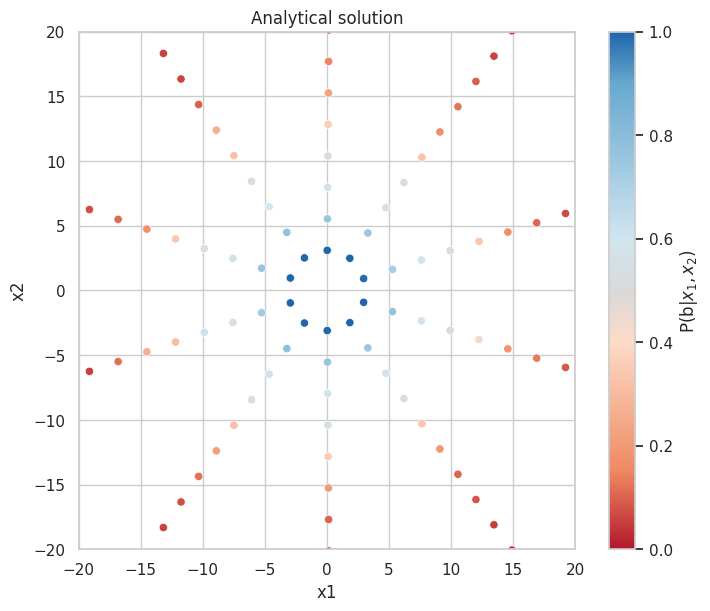

In [67]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize= (7,6), layout="constrained")
ax = plot_results(df, "P_blue_given_x", ax, "Analytical solution")
cmap = red_blue_cmap()
hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r'P(b|$x_1, x_2$)', ax=ax)

In [ ]:
def calculate_grid(nx:int, R2, R1_min, n_mc:int = 10):
    x1_lim = 25
    x2_lim = 25
    x1 = np.linspace(-x1_lim, x1_lim, nx)
    x2 = np.linspace(-x2_lim, x2_lim, nx)
    xx1, xx2 = np.meshgrid(x1, x2)
    df = pd.DataFrame(columns = ["x1", "x2"], index = range(len(xx1.flatten())))
    df["x1"] = xx1.flatten()
    df["x2"] = xx2.flatten()
    df["r_x"], df["a_x"] = cartesian_to_polar(df["x1"], df["x2"])
    df["P_red_and_x"] = np.zeros(len(df))
    df["P_blue_and_x"] = np.zeros(len(df))

    for i in tqdm(range(len(df))):
        if df["r_x"][i] < R1_min-R2:
            df["P_red_and_x"][i] = 0.5
            df["P_blue_and_x"][i] = 0.5
        else:
            df["P_red_and_x"][i] = P_c_and_x("red", df["x1"][i], df["x2"][i], R2, R1_min, n_mc = n_mc)
            df["P_blue_and_x"][i] = P_c_and_x("blue", df["x1"][i], df["x2"][i], R2, R1_min, n_mc = n_mc)
    df["P_x"] = df["P_red_and_x"] + df["P_blue_and_x"]
    df["P_red_given_x"] = df["P_red_and_x"]/df["P_x"]
    df["P_blue_given_x"] = df["P_blue_and_x"]/df["P_x"]
    df.to_csv(f"analytical_solution_grid_{nx}x{nx}_nMC_{n_mc}.csv")
    return df

In [ ]:
df_grid = calculate_grid(100, R2, R1_min, n_mc=50)

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [1:04:43<00:00,  2.58it/s]


In [ ]:
def plot_grid(grid_df, pred_key, fig, ax, nx:int = 100):
    x1_lim = 25
    x2_lim = 25

    cmap = red_blue_cmap()
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)

    ax.hist2d(x= grid_df["x1"], y= grid_df["x2"], weights=grid_df[pred_key], 
                bins = nx,
                norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False),
                cmap=cmap)
    
    ax.set_xlim(-x1_lim, x1_lim)
    ax.set_ylim(-x2_lim, x2_lim)

    return fig, ax

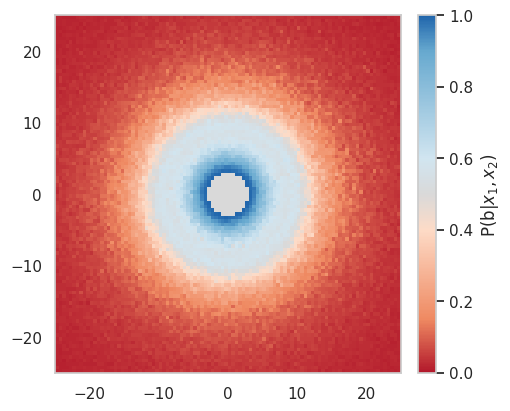

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize= (5,4), layout="constrained")
fig, ax = plot_grid(df_grid, "P_blue_given_x", fig, ax, 100)
cmap = red_blue_cmap()
hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r'P(b|$x_1, x_2$)', ax=ax)